In [1]:


import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput, Token)

import PostMetric
import pandas as pd

from helm.benchmark.metrics.statistic import Stat
from typing import Dict, Optional

from helm.benchmark.augmentations.perturbation_description import (
    PerturbationDescription)
from dataclasses import dataclass
from process_gens import *
from process_gen_utils import *



processGens=ProcessGens()

#wmt modes
# process_gen_mode="wmt_single"
# process_gen_mode="wmt_samples"
# process_gen_mode="wmt_single"
process_gen_mode="wmt_samples"
# process_gen_mode="wmt_sample_100"
# process_gen_mode="wmt_sample_50"
    # wmt_sample_100
    

compare_metric="example_comet"




do_norm_analysis=True
processGens.init_with_mode(process_gen_mode)
root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics = processGens.get_params()
examples_df, completions_df=get_dfs(processGens)
if(do_norm_analysis):
    for col in [compare_metric, 'output_logprob']:
        examples_df[col + '_norm'] = examples_df.groupby('instanceID')[col].transform(
            lambda x: (x - x.mean()) / x.std()
        )

dfs_by_model={}

for model_name in examples_df['model'].unique():
    filtered_df = examples_df[examples_df["model"]==model_name]
    dfs_by_model[model_name]=filtered_df

all_dfs_by_model=dfs_by_model
# if(len(models)>1):
    # all_dfs_by_model["all_models"]=examples_df

/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PyTorch version 2.6.0 available.


Init: process_gens_mode wmt_samples
calculate_gen_summary_dict
get_metrics_dict


/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using low

Index(['example_comet', 'beam_num', 'task_name', 'model', 'example_idx',
       'suite', 'instanceID', 'text', 'completion_length', 'output_logprob',
       'isCompletion', 'BLEU_1', 'BLEU_4'],
      dtype='object')
Num examples: 50000
Num completions: 5000


In [2]:
print(f"\t root_folder: {root_folder} \n \t num_beams_list {num_beams_list} \n \t models: {models} \n \t custom_metrics{[metric.name() for metric in custom_metrics]}"+ 
    f"\n \t task_names {task_names} \n \t suite_name {suite_name} \n \t instance_metrics {instance_metrics}")
# instanceGeneration=get_first(processGens.first_run_instances)
print(examples_df.head(2))
print("num examples" ,len(examples_df))
print("num_completions", len(completions_df))
print(f"compare_metric mean: ",examples_df[[compare_metric]].mean())
#current belief: for each run_folder combo, there will be 100 instances and 100 examples per instance

	 root_folder: snellius_copies/helm_output 
 	 num_beams_list [1] 
 	 models: ['allenai_OLMo_2_0425_1B_Instruct', 'allenai_OLMo_2_1124_7B_Instruct', 'allenai_OLMo_2_1124_13B_Instruct', 'meta_llama_Llama_3.2_1B_Instruct', 'meta_llama_Llama_3.1_8B_Instruct'] 
 	 custom_metrics['BLEU_1', 'BLEU_4']
 	 task_names ['wmt_14_language_pair_de_en_'] 
 	 suite_name sample_10_eval_1000 
 	 instance_metrics ['comet']
   example_comet  beam_num                    task_name  \
0       0.300900         1  wmt_14_language_pair_de_en_   
1       0.305558         1  wmt_14_language_pair_de_en_   

                             model  example_idx                suite  \
0  allenai_OLMo_2_0425_1B_Instruct            0  sample_10_eval_1000   
1  allenai_OLMo_2_0425_1B_Instruct            1  sample_10_eval_1000   

   instanceID                                               text  \
0           0  Input: a list of numbers 2 to 10 inclusive\n\n...   
1           0  Σημαντικότητα: είναι βασικός γεωκρατικός δημιο

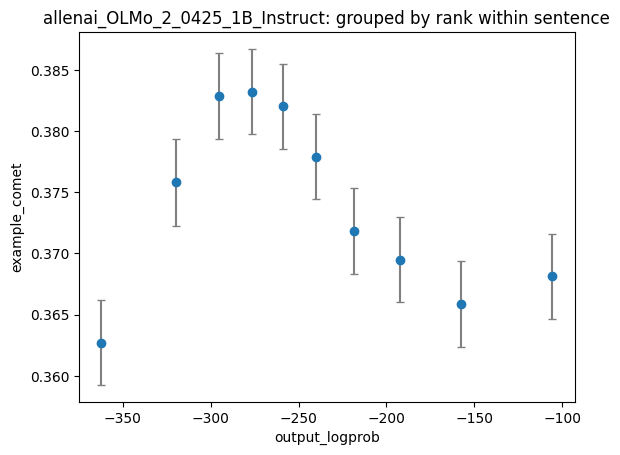

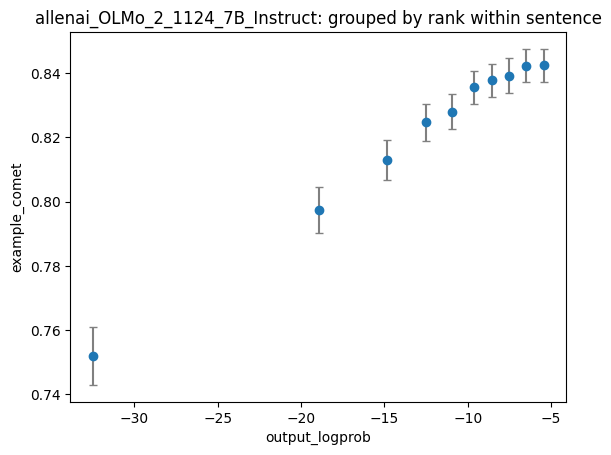

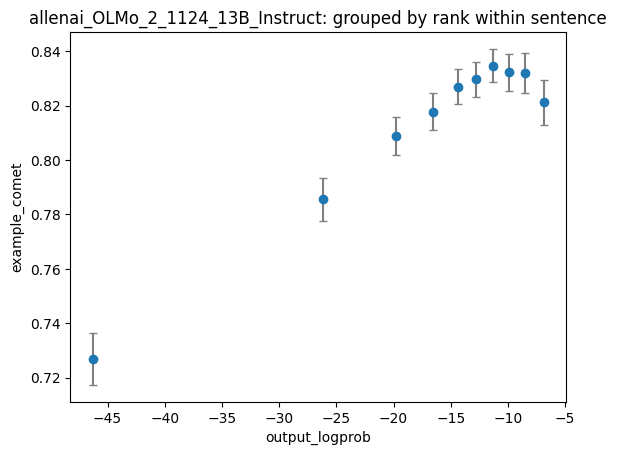

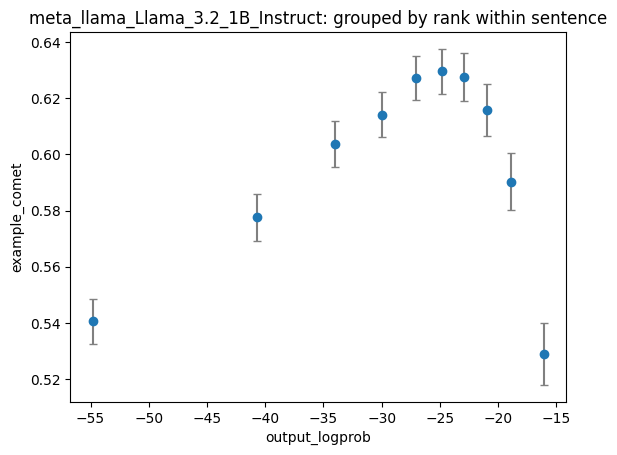

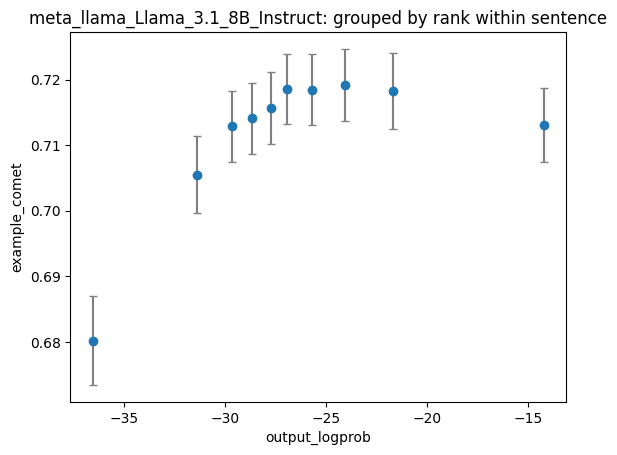

In [3]:

max_example_idx = examples_df["example_idx"].max()
plots_wide=1
num_models=len(dfs_by_model.keys())
plots_tall=math.ceil(num_models/plots_wide)

suptitle=""
axs=None
fig=None
# fig, axs = plt.subplots(plots_wide, plots_tall, figsize=(8, 8))


for idx, (model_name, filtered_df) in enumerate(dfs_by_model.items()):
    
    if axs is None:
        ax=None
    else:
        title=model_name
        if(num_models>1):
            axs_x=idx % plots_wide
            axs_y= math.floor(idx / plots_wide)
            ax=axs[axs_x, axs_y]
        else:
            ax=axs

    
    def calculate_title():
        return f"{model_name}: {suptitle}" if ax is None else model_name
    # plot by rank within sentence
    suptitle="grouped by rank within sentence"
    plot_grouped(df=filtered_df, xlabel="output_logprob",groupby='example_idx', ylabel=compare_metric, title=calculate_title(), ax=ax)
    # plot_spline(df=examples_df, xlabel="output_logprob", ylabel=compare_metric, ax=ax)

    
if fig is not None:
    fig.suptitle(title)
    fig.tight_layout()
    

In [4]:
#first: I calculate win rates

def get_iom_metrics_dict(df,compare_metric,ax=None):
    # plot_grouped(df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20):
    # grouped = df.groupby("example_idx")[[xlabel, ylabel]].agg(['mean', 'count', 'std'])

    max_example_idx = df["example_idx"].max()
    num_ranks=max_example_idx+1
    # pivoted = df.pivot(columns='example_idx', values=compare_metric )
    # pivoted_mean=pivoted.mean()
    pivoted = df.pivot(index="instanceID",columns="example_idx", values=compare_metric )
    # print(pivoted.head(2))
    mean_pivoted=pivoted.mean()
    ave_val=mean_pivoted.mean()

    # pivoted_x = df.pivot(columns="example_idx", values="output_logprob").mean()
    
    best_rank = mean_pivoted.idxmax()
    ranks_effected=best_rank
    percent_effected=ranks_effected / num_ranks
    score_diff=0

    win_rate_by_col=[-1]*(best_rank+1)
    for compare_rank in range(best_rank+1):
        win_rate_col_name=f"win_rate_{compare_rank}"
        pivoted[win_rate_col_name] = pivoted.apply( lambda row: get_win_rate(row,compare_rank, best_rank) , axis=1)
        win_rate_by_col[compare_rank] = pivoted[win_rate_col_name].mean()

    win_rate=win_rate_by_col[0]
    # print("win_rate_by_col",win_rate_by_col)

    for compare_rank in range(best_rank):
        score_diff+= mean_pivoted[best_rank]-mean_pivoted[compare_rank]
    

    effect_size=score_diff*percent_effected
    average_diff=score_diff/ranks_effected
    effect_diff=mean_pivoted[best_rank]-mean_pivoted[0]

    average_diff_norm=average_diff/ave_val
    effect_diff_norm=effect_diff/ave_val
    effect_size_norm=effect_size /ave_val

    return {
        # "effect_size": effect_size,
        # "average_diff": average_diff,
        # "effect_diff": effect_diff,
        "percent_effected":percent_effected,
        "win_rate":win_rate,

        "average_diff_norm":average_diff_norm,
        "effect_diff_norm":effect_diff_norm,
        "effect_size_norm":effect_size_norm
    }



iom_metrics_dict_by_model={}
for idx, (model_name, filtered_df) in enumerate(dfs_by_model.items()):
    # print(model_name)
    iom_metrics_dict_by_model[model_name]=get_iom_metrics_dict(filtered_df, compare_metric=compare_metric)
    print(iom_metrics_dict_by_model[model_name])


# 14% effected, 






    


{'percent_effected': np.float64(0.6), 'win_rate': np.float64(0.414), 'average_diff_norm': np.float64(0.028596536266810378), 'effect_diff_norm': np.float64(0.04036588802671208), 'effect_size_norm': np.float64(0.10294753056051736)}
{'percent_effected': np.float64(0.0), 'win_rate': np.float64(0.5), 'average_diff_norm': np.float64(nan), 'effect_diff_norm': np.float64(0.0), 'effect_size_norm': np.float64(0.0)}
{'percent_effected': np.float64(0.3), 'win_rate': np.float64(0.5765), 'average_diff_norm': np.float64(0.0077303963058847815), 'effect_diff_norm': np.float64(0.01676136059307509), 'effect_size_norm': np.float64(0.006957356675296303)}
{'percent_effected': np.float64(0.4), 'win_rate': np.float64(0.365), 'average_diff_norm': np.float64(0.06544304175205094), 'effect_diff_norm': np.float64(0.16909697952579375), 'effect_size_norm': np.float64(0.10470886680328152)}
{'percent_effected': np.float64(0.2), 'win_rate': np.float64(0.472), 'average_diff_norm': np.float64(0.004926201975305446), 'effe

/var/folders/w4/6m47nb7x1cv2hsxbb89dmcz80000gn/T/ipykernel_34617/2863645835.py:37: RuntimeWarning: invalid value encountered in scalar divide
  average_diff=score_diff/ranks_effected


In [5]:
print(iom_metrics_dict_by_model)

{'allenai_OLMo_2_0425_1B_Instruct': {'percent_effected': np.float64(0.6), 'win_rate': np.float64(0.414), 'average_diff_norm': np.float64(0.028596536266810378), 'effect_diff_norm': np.float64(0.04036588802671208), 'effect_size_norm': np.float64(0.10294753056051736)}, 'allenai_OLMo_2_1124_7B_Instruct': {'percent_effected': np.float64(0.0), 'win_rate': np.float64(0.5), 'average_diff_norm': np.float64(nan), 'effect_diff_norm': np.float64(0.0), 'effect_size_norm': np.float64(0.0)}, 'allenai_OLMo_2_1124_13B_Instruct': {'percent_effected': np.float64(0.3), 'win_rate': np.float64(0.5765), 'average_diff_norm': np.float64(0.0077303963058847815), 'effect_diff_norm': np.float64(0.01676136059307509), 'effect_size_norm': np.float64(0.006957356675296303)}, 'meta_llama_Llama_3.2_1B_Instruct': {'percent_effected': np.float64(0.4), 'win_rate': np.float64(0.365), 'average_diff_norm': np.float64(0.06544304175205094), 'effect_diff_norm': np.float64(0.16909697952579375), 'effect_size_norm': np.float64(0.104

dict_keys(['olmo', 'llama'])


/var/folders/w4/6m47nb7x1cv2hsxbb89dmcz80000gn/T/ipykernel_34617/391123208.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


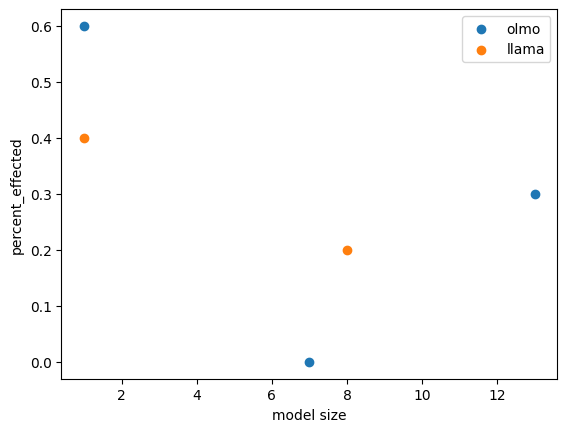

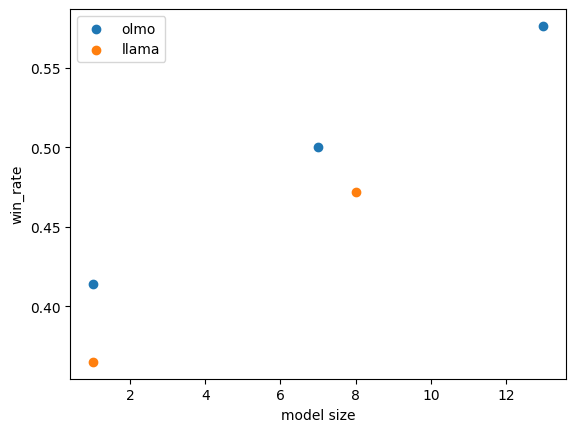

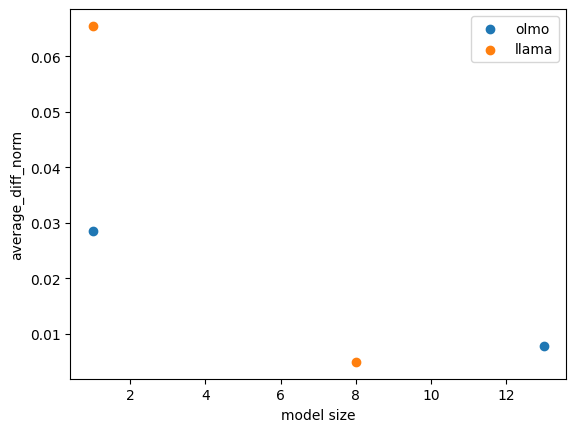

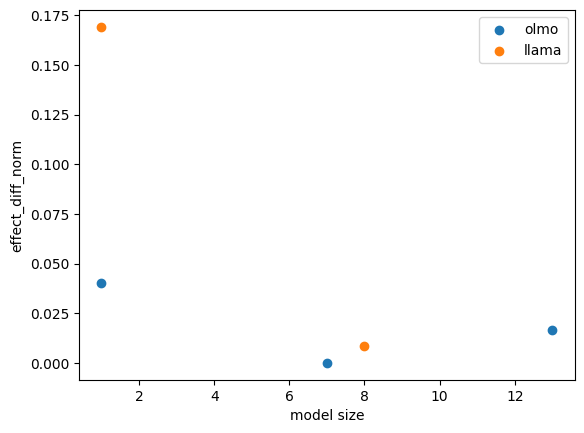

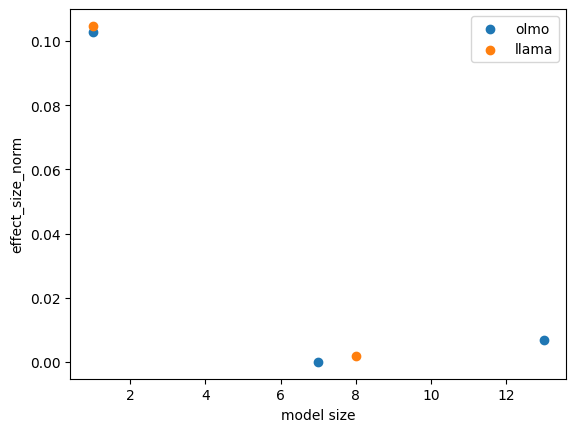

In [6]:
#Here is current goal:

#each metric gets a graph
#each suite gets a line
#x axis is model size
#y axis is metric



def append_to_dict(dict, key_list, value):
    cur_key=key_list[0]
    
    #make sure it exists
    if cur_key not in dict.keys():
        dict[cur_key]={}

    #append recursively if not
    if(len(key_list)>1):
        append_to_dict(dict[cur_key], key_list[1:], value)
    else:
        dict[cur_key]=value


iom_metrics_dict_by_properties={}

for (model_name, iom_metrics_dict) in iom_metrics_dict_by_model.items():
    model_details = get_model_details(model_name)

    append_to_dict(iom_metrics_dict_by_properties, [ model_details["suite"], model_details["model_type"],  model_details["size"] ], iom_metrics_dict)

print(iom_metrics_dict_by_properties.keys())
    

iom_metric_keys=next(iter(iom_metrics_dict_by_model.values())).keys()
for iom_metric in iom_metric_keys: 
    fig, ax = plt.subplots()

    
    for suite in iom_metrics_dict_by_properties.keys():
        for model_type in iom_metrics_dict_by_properties[suite].keys():
            x=[]
            y=[]
            for size in iom_metrics_dict_by_properties[suite][model_type].keys():
                value=iom_metrics_dict_by_properties[suite][model_type][size][iom_metric]
                x.append(size)
                y.append(value)
            ax.scatter(x,y, label=suite)
    ax.set_xlabel('model size')
    ax.set_ylabel(iom_metric)
    ax.legend()
    fig.show()
            
    # iom_metrics_dict[iom_metric]




In [7]:
# 00:24:50